In [89]:
# Package Imports
import pandas as pd
import numpy as np
import pickle

# 
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from imblearn.pipeline import Pipeline as ImPipeline

## Helper Functions

In [58]:
# This function will allow for quick cross-validation of the chosen score for each of our models.
def cross_val(model, X, y, custom_scorer, kfolds=5):
    """ Perform cross-validated scoring and store/print results """
    results = cross_val_score(model, X, y, cv=kfolds, scoring=custom_scorer)
    mean = np.mean(results)
    median = np.median(results)
    std = np.std(results)
    if custom_scorer == accuracy:
        print(f"Mean accuracy score: ", {mean}, ".")
        print(f"Median acuracy score: ", {median}, ".")
        print(f"Standard Deviation in accuracy: ", {std}, ".") 
    elif custom_scorer == custom_f1:
        print(f"Mean f1 score: ", {mean}, ".")
        print(f"Median f1 score: ", {median}, ".")
        print(f"Standard Deviation in f1 score: ", {std}, ".") 
    elif custom_scorer == multi_prec:
        print(f"Mean precision score: ", {mean}, ".")
        print(f"Median precision score: ", {median}, ".")
        print(f"Standard Deviation in precision score: ", {std}, ".") 
    elif custom_scorer == multi_rec:
        print(f"Mean recall score: ", {mean}, ".")
        print(f"Median recall score: ", {median}, ".")
        print(f"Standard Deviation in recall score: ", {std}, ".") 

# Modeling

In [79]:
max_features = None

In [70]:
# Read in the data
df = pd.read_csv('../data/train_cleaned.csv', usecols=['sentiment', 'text_cleaned', 'toks'])

In [71]:
df.head(25)

,sentiment,text_cleaned,toks
0,2,lovely pat one great voice generation listen c...,"['lovely', 'pat', 'one', 'great', 'voice', 'ge..."
1,2,despite fact play small portion game music hea...,"['despite', 'fact', 'play', 'small', 'portion'..."
2,1,bought charger jul work ok design nice conveni...,"['bought', 'charger', 'jul', 'work', 'ok', 'de..."
3,2,check maha energy's website powerex mh c f cha...,"['check', 'maha', ""energy's"", 'website', 'powe..."
4,2,review quite bit combo player hesitant due unf...,"['review', 'quite', 'bit', 'combo', 'player', ..."
5,1,also begin incorrect disc problem i've read vc...,"['also', 'begin', 'incorrect', 'disc', 'proble..."
6,1,love style couple year dvd give problem even w...,"['love', 'style', 'couple', 'year', 'dvd', 'gi..."
7,1,cannot scroll dvd menu set vertically triangle...,"['cannot', 'scroll', 'dvd', 'menu', 'set', 've..."
8,2,exotic tale orient dr shen fu weird tale magaz...,"['exotic', 'tale', 'orient', 'dr', 'shen', 'fu..."
9,1,firstly enjoy format tone book author address ...,"['firstly', 'enjoy', 'format', 'tone', 'book',..."


In [72]:
print(df.isna().sum())
df[df['text_cleaned'].isna()]

sentiment       0
text_cleaned    1
toks            0
dtype: int64


,sentiment,text_cleaned,toks
369851,2,NaN,[]


In [73]:
# Drop lone NaN value in 'text_cleaned'
df.drop(index=[369851], inplace=True)

In [74]:
X = df['text_cleaned']
y = df['sentiment']

In [80]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                ('vect', TfidfVectorizer(max_features=max_features)),
                                ('dc', DummyClassifier(strategy='most_frequent',
                                                           random_state=42))
                              ]
)

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.500001250003125


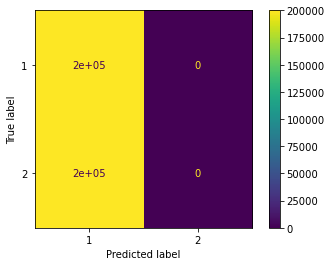

In [81]:
# Fit dummy pipe on the training data and plot confusion matrix
dummy_pipe.fit(X, y)
dummy_yhat = dummy_pipe.predict(X)
plot_confusion_matrix(dummy_pipe, X, y);
print(accuracy_score(y, dummy_yhat))

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8430846077115193


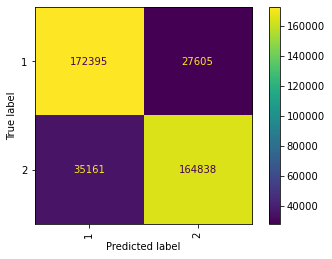

In [82]:
# Instantiate the Multinomial Naieve Bayes Pipeline
mnb_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('mnb', MultinomialNB())
                            ]
)

# Fit MNB pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X, y)
mnb_yhat = mnb_pipe.predict(X)
plot_confusion_matrix(mnb_pipe, X, y, xticks_rotation=90);
print(accuracy_score(y, mnb_yhat))

In [83]:
# Obtained cross-validated accuracy score
cross_validate(mnb_pipe, X, y)

{'fit_time': array([7.42021608, 7.89667916, 7.4685812 , 7.86654496, 7.48144317]),
 'score_time': array([1.74008894, 1.68158007, 1.84263182, 1.84213591, 1.64812279]),
 'test_score': array([0.8163375 , 0.8132    , 0.814725  , 0.810225  , 0.80948512])}

In [96]:
# Instantiate the Random Forest Pipeline
rf_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('rf', RandomForestClassifier())
                            ]
)

# Fit RF pipe on the training data, get predictions and plot confusion matrix
# rf_pipe.fit(X, y)
rf_yhat = rf_pipe.predict(X)
plot_confusion_matrix(rf_pipe, X, y);
print(accuracy_score(y, rf_yhat))

NotFittedError: The TF-IDF vectorizer is not fitted

In [86]:
# Obtained cross-validated accuracy score
# cross_validate(rf_pipe, X, y)

{'fit_time': array([1830.52545214, 1831.86812997, 1832.6002512 , 1840.15665793,
        1856.76238298]),
 'score_time': array([8.741611  , 8.63665485, 8.63135886, 8.6168921 , 8.63820219]),
 'test_score': array([0.836875  , 0.8388375 , 0.839625  , 0.839225  , 0.84041051])}

In [88]:
with open ('rf_pkl', 'wb') as files:
    pickle.dump(rf_pipe, files)

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8551421378553447


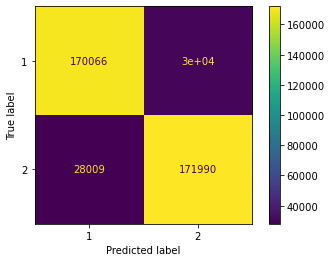

In [93]:
# Instantiate the SDGC Classifier pipeline
sgdc_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('sdgc', SGDClassifier(random_state=42))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_pipe.fit(X, y)
sgdc_yhat = sgdc_pipe.predict(X)
plot_confusion_matrix(sgdc_pipe, X, y);
print(accuracy_score(y, sgdc_yhat))

In [95]:
# Obtained cross-validated accuracy score
cross_validate(sgdc_pipe, X, y)

{'fit_time': array([7.66925502, 7.57306695, 7.66156888, 7.67923212, 7.607234  ]),
 'score_time': array([1.68142796, 1.6727438 , 1.67781806, 1.65506506, 1.62950611]),
 'test_score': array([0.84715   , 0.8508    , 0.8500125 , 0.8504375 , 0.85187315])}